# Import libraries

In [74]:
globals().clear
from dotenv import load_dotenv
from os import getenv
import time
import pandas as pd
import numpy
import seaborn as sns
sns.set()
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogLocator

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Load environment variables

In [13]:
load_dotenv()
DB_HOST = getenv('DB_HOST')
DB_USER = getenv('DB_USER')
DB_PASSWORD = getenv('DB_PASSWORD')

# Connect to database hosting the data

In [14]:
def connectDB():
    from sqlalchemy import create_engine
    return create_engine(f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:3306/ats_db')

In [15]:
cnx = connectDB()

# Load bonds, commodities and index data from database
<!-- **Change the value of the 'indexName' variabe to choose index (case sensitive)**   -->
<!-- >**Options:**  
S&P 500  
NASDAQ Composite  
Dow Jones Industrial Average  
Russell 3000  
FTSE 100   -->

In [16]:
def getCommodities(minDate, maxDate):
    # Fetch indexes
    index = pd.read_sql_query(f'''SELECT ind.indexName, hv.date, hv.high, hv.low FROM historical_index_values hv
    JOIN indexes ind ON hv.index_id = ind.id WHERE date > "{minDate}" AND date < "{maxDate}";''', con=cnx)

    # Fetch commodities
    commodities = pd.read_sql_query(f'''SELECT c.commodityName, hv.date, hv.high, hv.low FROM historical_commodity_values hv
    JOIN commodities c ON hv.commodity_id = c.id WHERE date > "{minDate}" AND date < "{maxDate}";''', con=cnx)

    # Fetch bonds
    bonds = pd.read_sql_query(f'''SELECT b.treasuryName, bv.date, bv.1_month, bv.2_month, bv.3_month, bv.6_month,
    bv.1_year, bv.2_year, bv.3_year, bv.5_year, bv.7_year, bv.10_year, bv.20_year, bv.30_year FROM bond_values bv
    JOIN bonds b ON bv.bond_id = b.id WHERE date > "{minDate}" AND date < "{maxDate}";''', con=cnx)

    return [index,commodities,bonds]

In [17]:
index, commodities, bonds = getCommodities('2021-06-28', '2024-06-27')

# Load stocks data from database
**Add the stock symbols in the 'symbols' list to choose stocks (case sensitive)**  
*[List of stocks](./stocksList.ipynb)*

In [18]:
def getStocks(symbols, minDate, maxDate):
    stocks = {}
    for symbol in symbols:
        stocks[symbol] = pd.read_sql_query(f'''SELECT c.companyName, hv.date, hv.high, hv.low
        FROM historical_stock_values hv JOIN companies c ON hv.company_id=c.id
        WHERE c.symbol="{symbol}" AND date > "{minDate}" AND date < "{maxDate}";''', con=cnx)
        stocks[symbol]['date'] = pd.to_datetime(stocks[symbol]['date'], format ='%Y-%m-%d')
    # stocks['AAPL'].head()
    
    # Top 10 stocks
    top = pd.read_sql_query(f'''SELECT c.symbol FROM historical_stock_values hv JOIN companies c ON hv.company_id=c.id
    ORDER BY hv.date DESC, hv.volume DESC LIMIT 10;''', con=cnx)
    topStocks = {}
    for symbol in top.symbol:
        topStocks[symbol] = pd.read_sql_query(f'''SELECT c.companyName, hv.date, hv.high, hv.volume
        FROM historical_stock_values hv JOIN companies c ON hv.company_id=c.id
        WHERE c.symbol="{symbol}" AND date > "{minDate}" AND date < "{maxDate}";''', con=cnx)
        topStocks[symbol]['date'] = pd.to_datetime(topStocks[symbol]['date'], format ='%Y-%m-%d')
    # topStocks['AAPL'].head()

    return [stocks, topStocks]

In [19]:
symbols = ['AAPL','NVDA','MSFT','CSCO','AMZN','GOOGL']
stocks, topStocks = getStocks(symbols, '2021-06-28', '2024-06-27')

# Plot indices graph

In [20]:
def plotIndexes(data):
    plt.figure(figsize=(20,10))
    sns.set(style='ticks')
    sns.lineplot(data=data,x='date',y='high', hue='indexName',linewidth=2)
    plt.figtext(0.5, 0.01, f'Fig 1: Historical price data of indexes', ha='center')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    # plt.xticks(rotation=90)    
    # sns.set_theme(style='darkgrid')
    # sns.displot(data=index,x='date',y='high', col='indexName', col_wrap=2)

    # plt.tight_layout()
    plt.show()

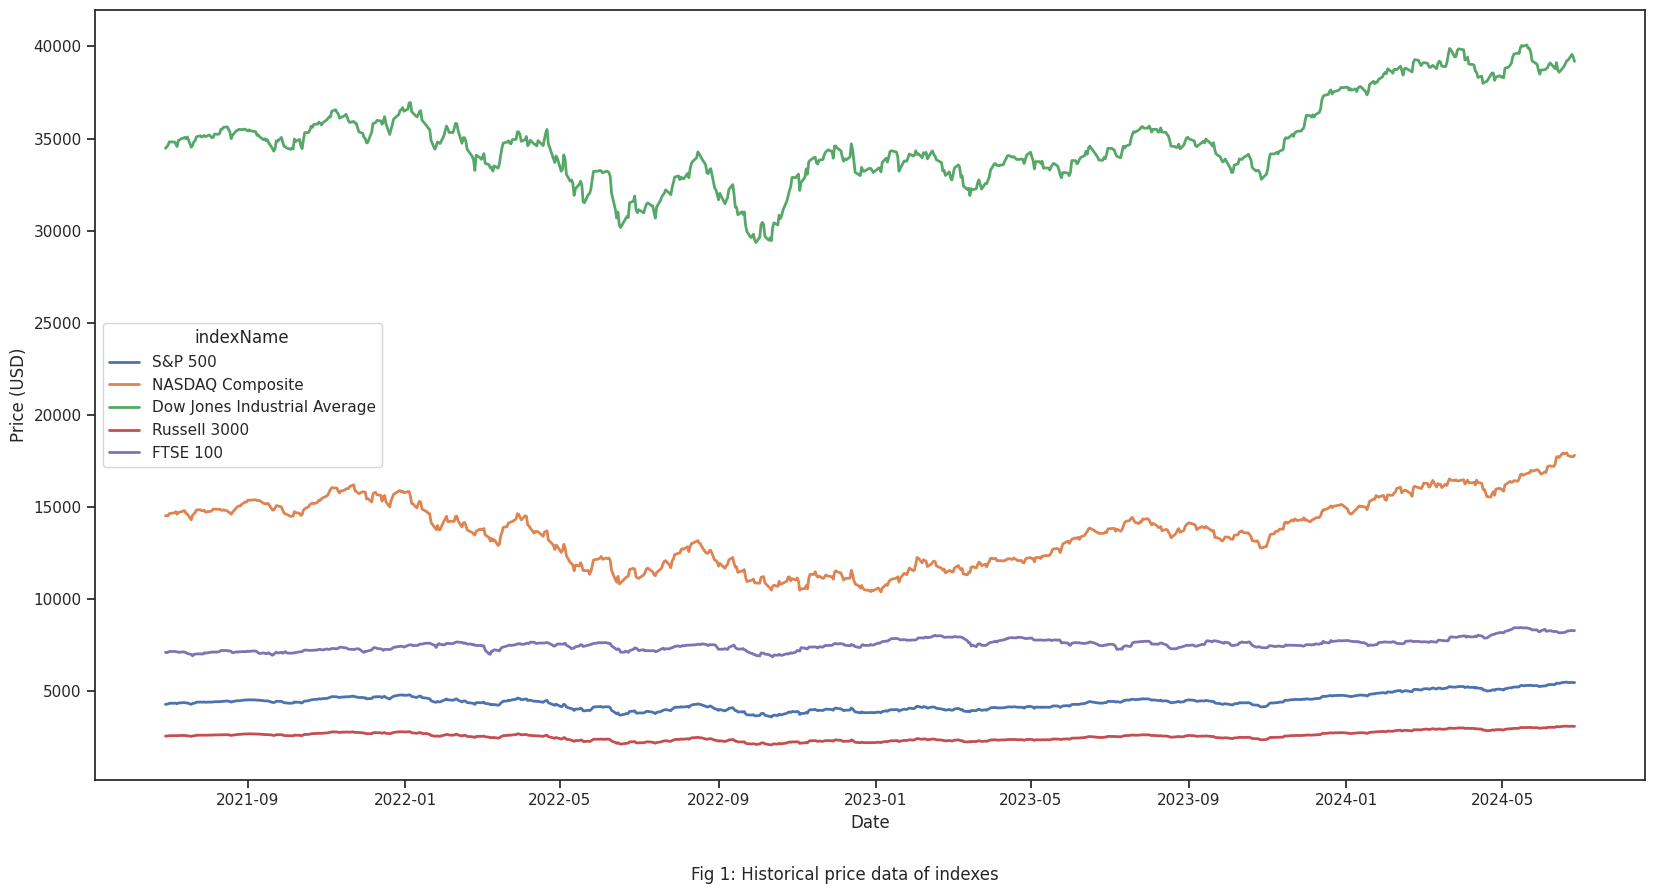

In [21]:
plotIndexes(index)

# Plot commodities graph

In [30]:
def plotCommodities(data):
    plt.figure(figsize=(20,10))
    sns.set(style='ticks')
    sns.lineplot(data=commodities,x='date',y='high', hue='commodityName', linewidth=1)
    plt.legend(loc='upper left')
    plt.figtext(0.5, 0.01, f'Fig 2: Historical price data of commodities', ha='center')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.yscale('log')
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    plt.gca().yaxis.set_major_formatter(formatter)

    # Manual yticks
    plt.yticks([1, 10, 50, 100, 1000, 2000, 5000], [1, 10, 50, 100, 1000, 2000, 5000])
    
    # Auto yticks
    # plt.gca().yaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=15))

    # plt.tight_layout()
    plt.show()
    

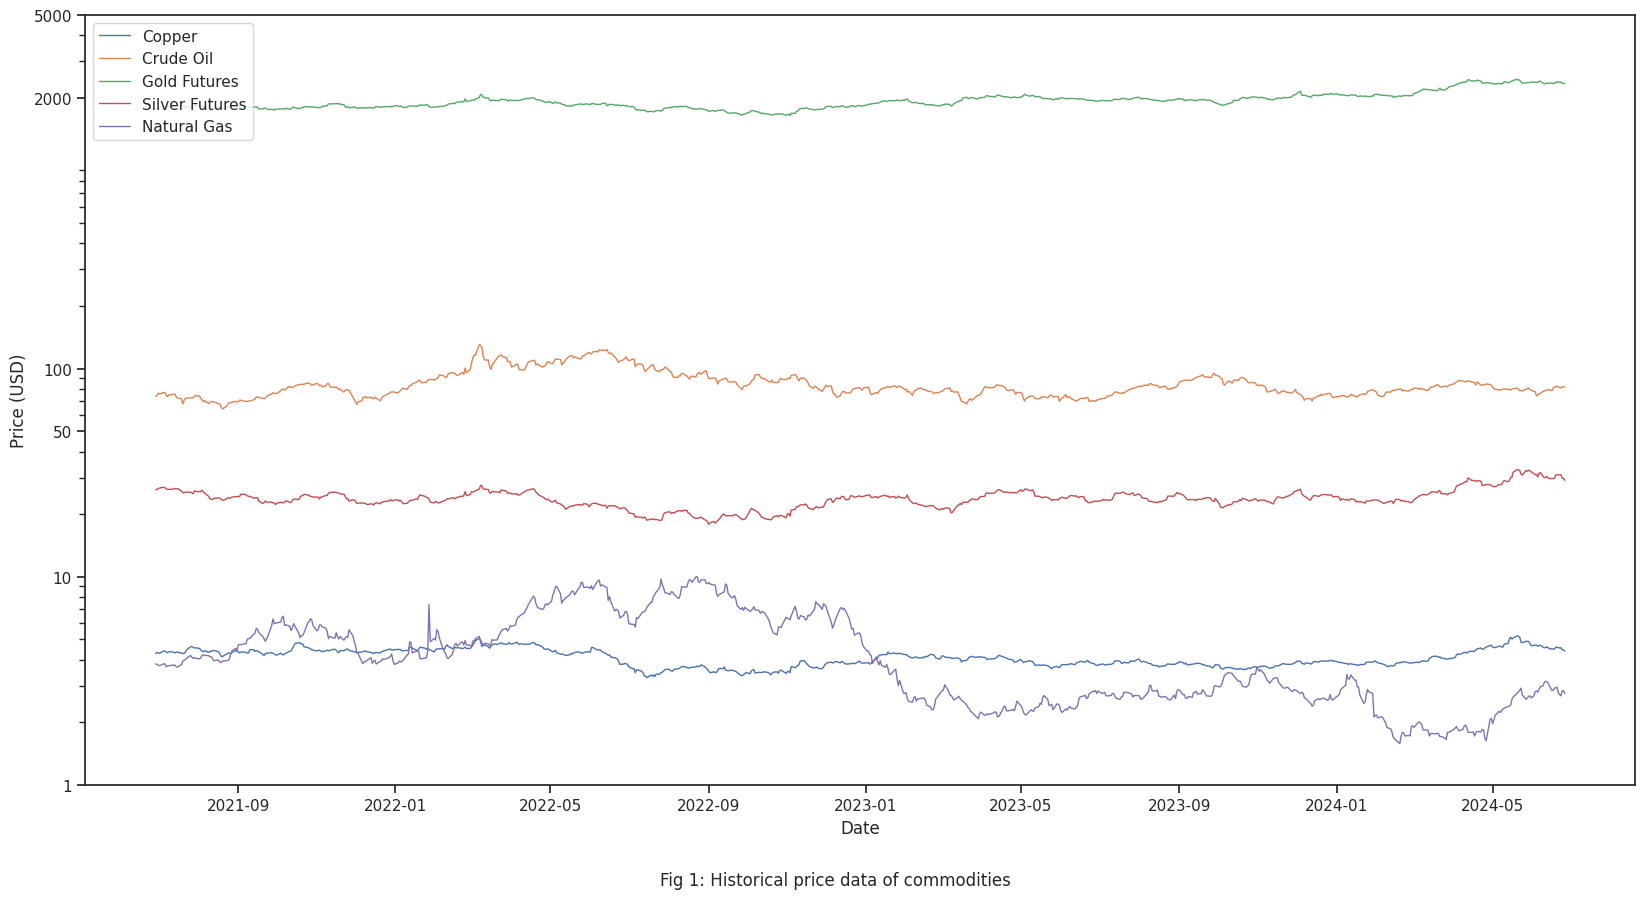

In [31]:
plotCommodities(commodities)

# Plot bond graph

In [34]:
def plotBond(bond):
    bond_maturityList = bonds.columns.tolist()
    bond_maturityList.remove('treasuryName')
    bond_maturityList.remove('date')
    plt.figure(figsize=(20,10))
    sns.set(style='ticks')
    
    for maturity in bond_maturityList:
        sns.lineplot(data=bonds,x='date',y=maturity, label=maturity, linewidth=1)
    plt.figtext(0.5, 0.01, f'Fig 3: Historical price data of US Treasury Bond', ha='center')
    plt.ylabel('Yield (%)')
    plt.xlabel('Date')

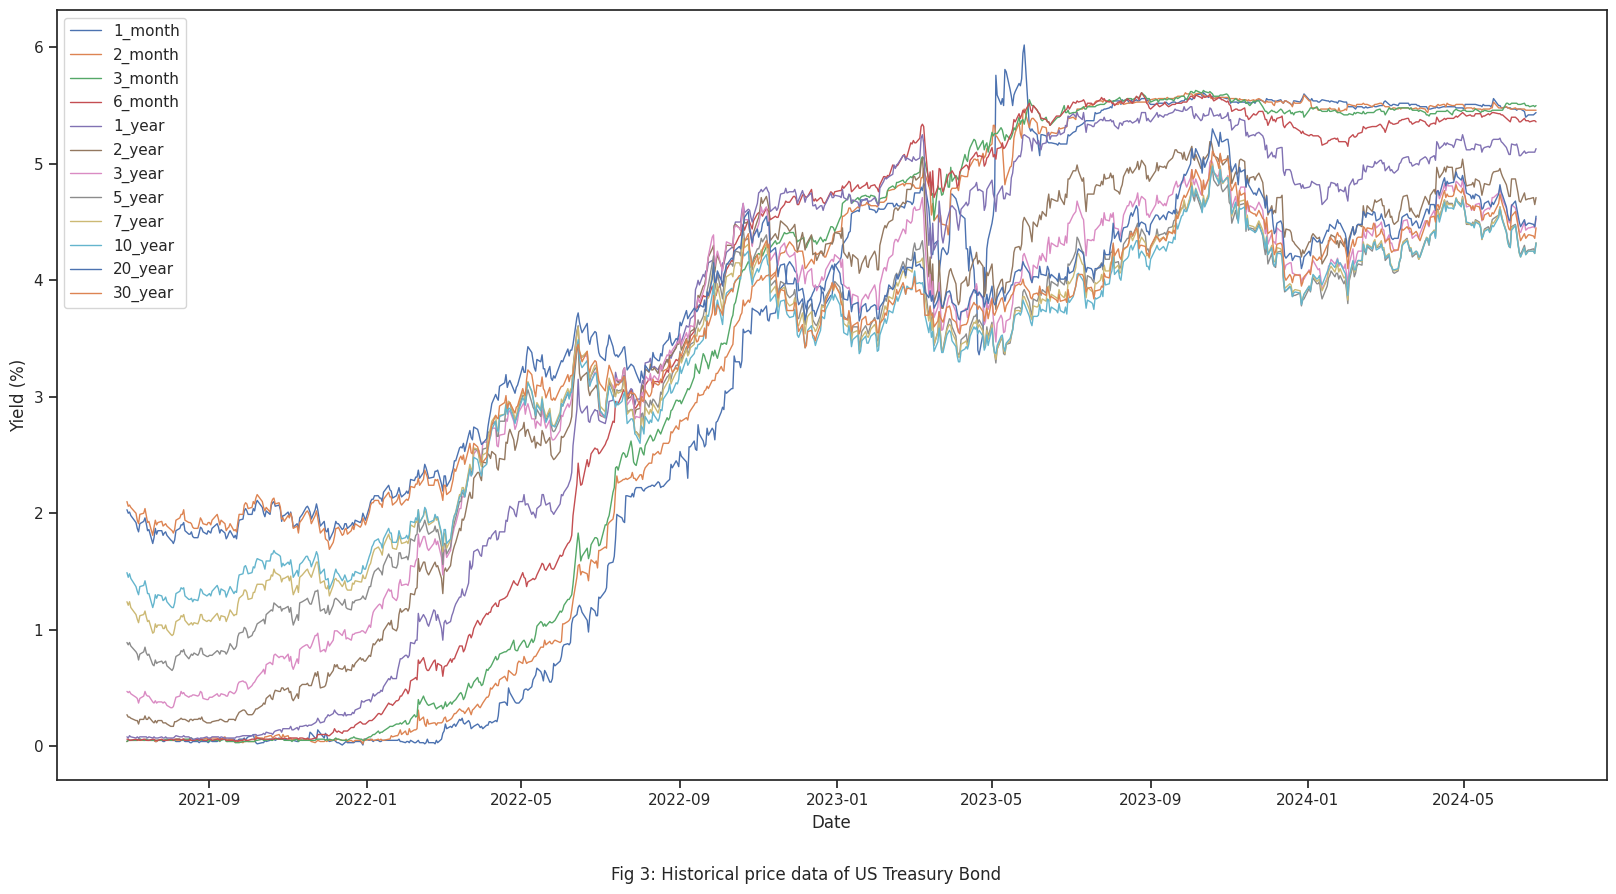

In [35]:
plotBond(bonds)

# Plot Top 10 stocks

In [49]:
def plotTopStocks(topStocks):
    plt.figure(figsize=(20,10))
    sns.set(style='ticks')
    for symbol in topStocks:
        sns.lineplot(data=topStocks[symbol],x='date',y='high',label=topStocks[symbol].companyName[0],linewidth=1)
    plt.figtext(0.5, 0.01, f'Fig 4: Historical price data of top 10 current stocks with highest volume', ha='center')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')

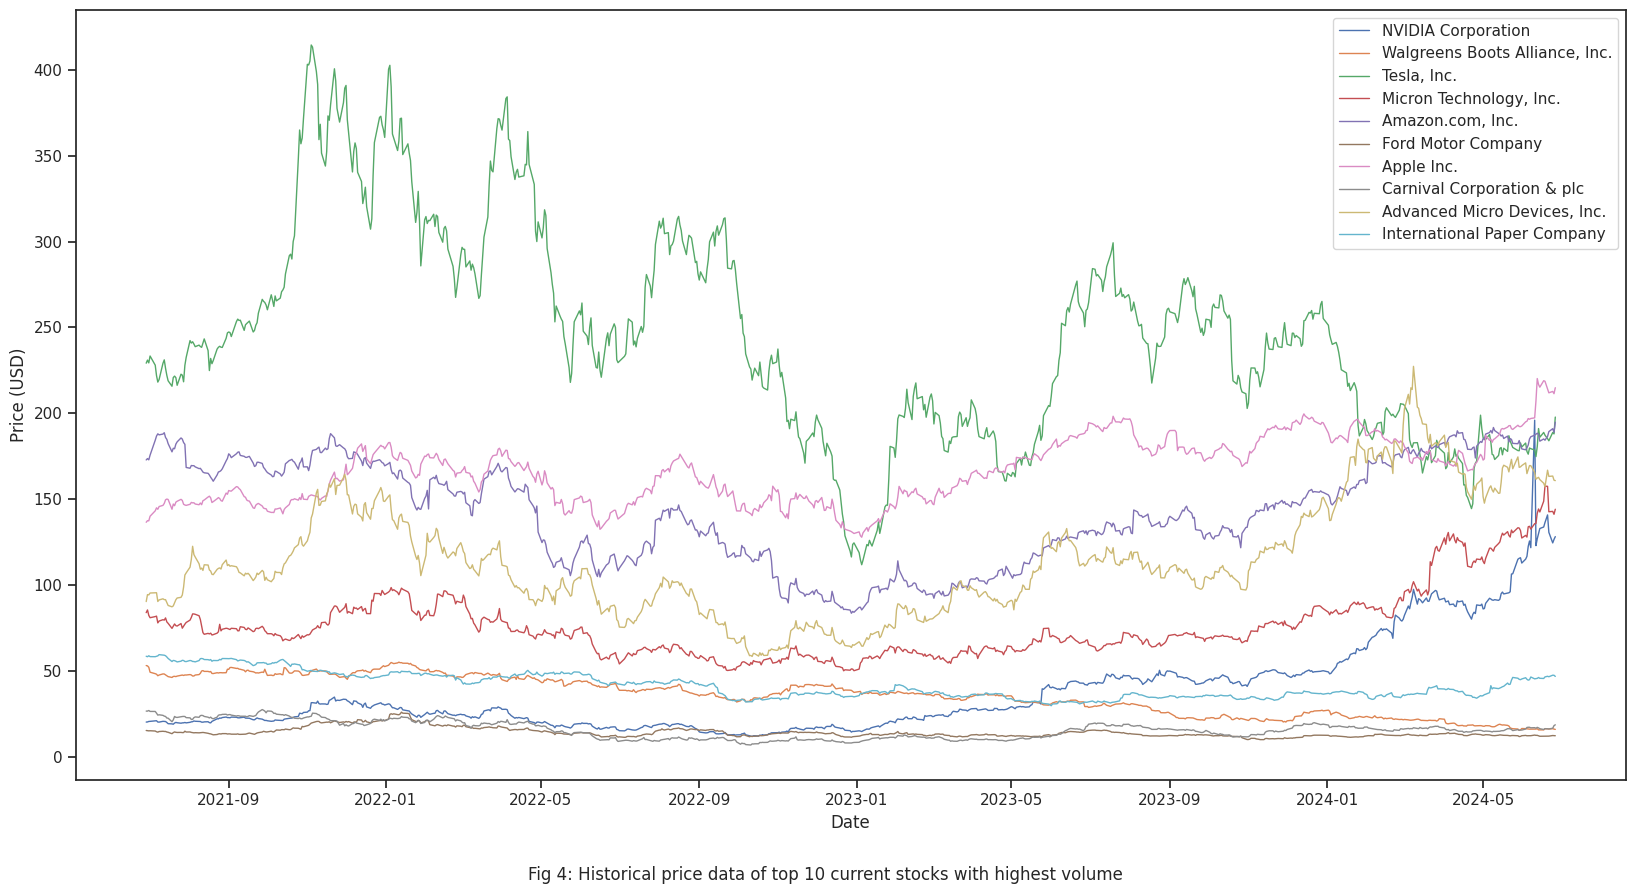

In [50]:
plotTopStocks(topStocks)

# Plot selected stocks graphs

In [72]:
def plotSelectedStocks(stocks):
    plt.figure(figsize=(20,10))
    sns.set(style='ticks')
    for symbol in stocks.keys():
        sns.lineplot(data=stocks[symbol],x='date',y='high', label=f'{stocks[symbol]["companyName"][0]}', linewidth=1)    
    plt.figtext(0.5, 0.01, f'Fig 5: Historical price data of selected stocks', ha='center')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    # plt.yscale('log')
    # formatter = ScalarFormatter()
    # formatter.set_scientific(False)
    # plt.gca().yaxis.set_major_formatter(formatter)

    # Manual yticks
    # plt.yticks([1, 10, 50, 100, 2000, 5000], [1, 10, 50, 100, 2000, 5000])
    
    # Auto yticks
    # plt.gca().yaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))

    # plt.tight_layout()
    plt.show()

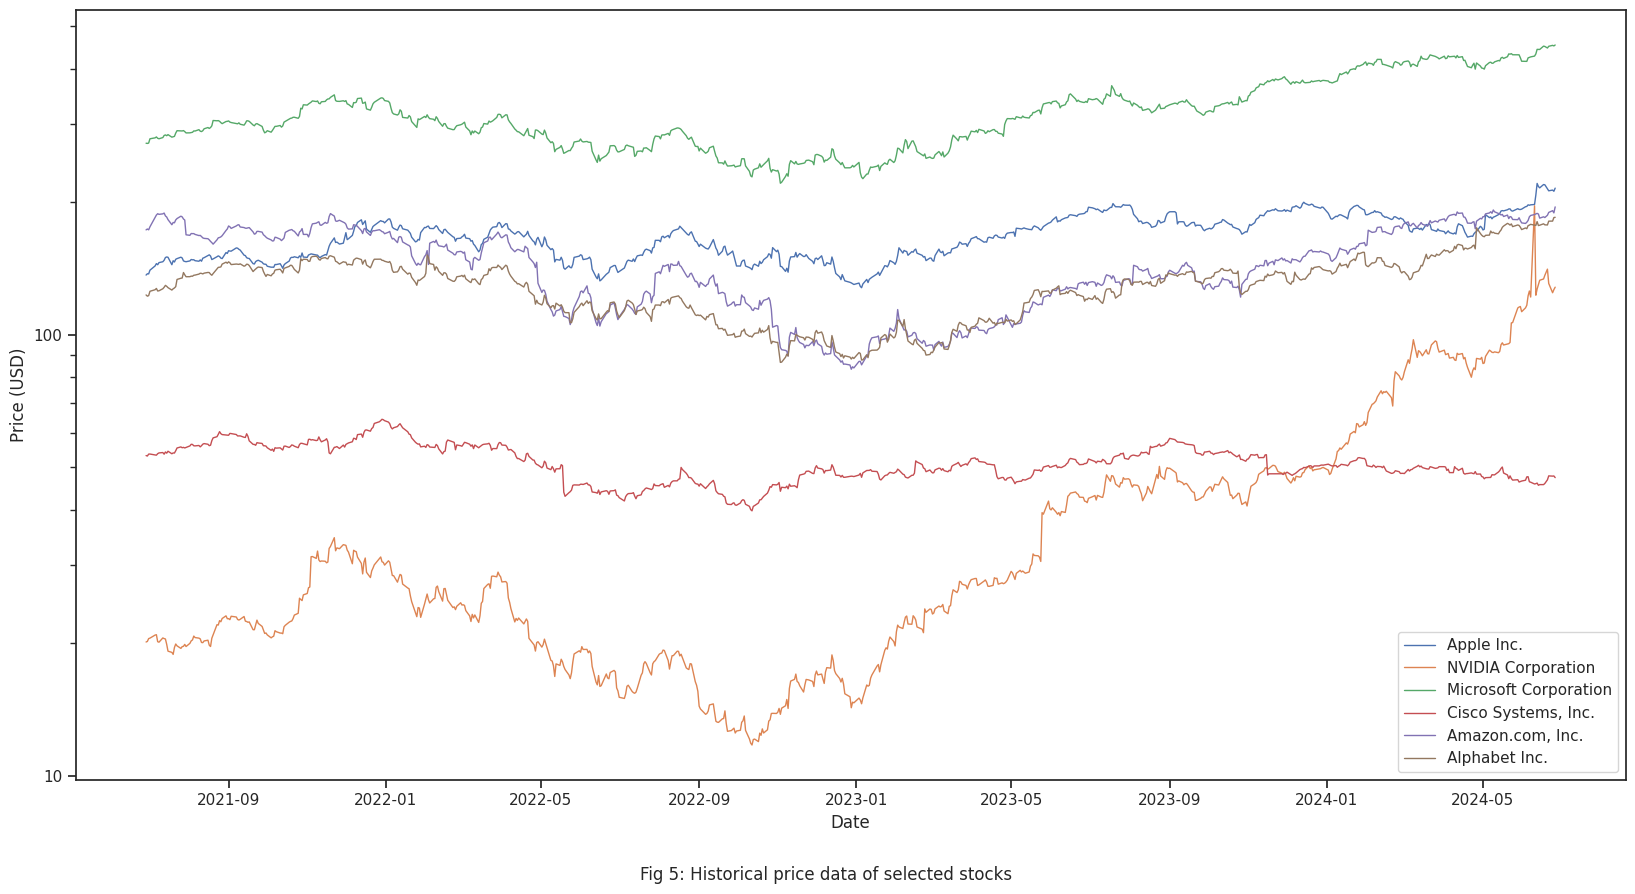

In [73]:
plotSelectedStocks(stocks)